# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Analysis of variance:", Part 2


## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

from patsy import dmatrices

from patsy.contrasts import Treatment
from patsy.contrasts import Sum
from patsy.contrasts import Diff


import warnings

D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


----
## Analysis of Variance Details

We load the dataset that relates job performance evaluation (JPERF) to minority status (MINORITY), and initial work test (TEST) results.

### Load Dataset

In [5]:
data = pd.read_csv('../data/jobtest.txt', sep='\t')

In [6]:
data.head()

,TEST,MINORITY,JPERF
0,0.28,1,1.83
1,0.97,1,4.59
2,1.25,1,2.97
3,2.46,1,8.14
4,2.51,1,8.00


In [7]:
data['MINORITY'].unique()

array([1, 0], dtype=int64)

### Visualize Data

We use Seaborn to produce a variety of different graphics

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


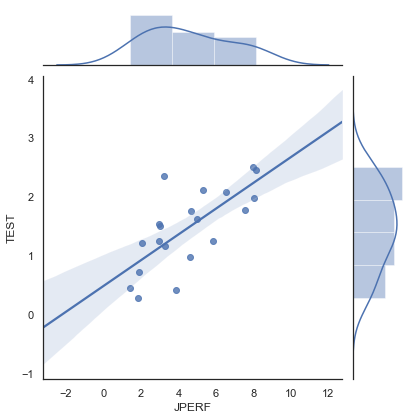

In [8]:
sns.set(style="white")
_ = sns.jointplot('JPERF', 'TEST', data=data, kind='reg')

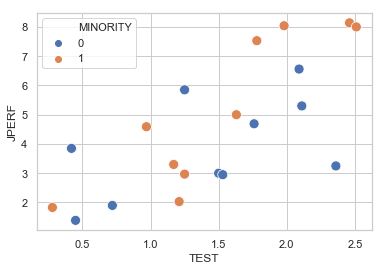

In [9]:
sns.set_style("whitegrid")
_ = sns.scatterplot(
    'TEST', 'JPERF', hue='MINORITY', data=data, s=100
)

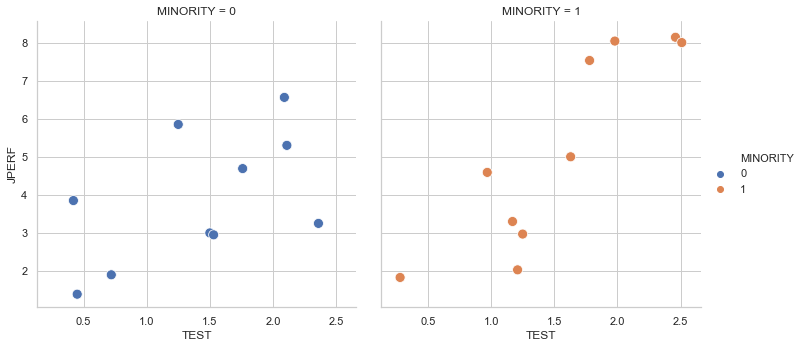

In [10]:
_ = sns.relplot(
    'TEST',
    'JPERF',
    hue='MINORITY',
    col='MINORITY',
    data=data,
    s=100,
)

### Perform Linear Regression

Declare the ```MINORITY```  to be a categorical variable

In [11]:
data['MINORITY'] = data['MINORITY'].astype('category')

Run the Ordinary Least Squares fit.  We specify a model where Job Performance depends upon Test Results, Minority status, and the interaction between these variables

In [12]:
res1 = ols(
    'JPERF ~ TEST:MINORITY + MINORITY + TEST', data=data
).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           0.000451
Time:                        20:35:44   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.0103      1.050      1.914      0.074      -0.216       4.236
MINORITY[T.1]         -1.9132      1.540     -1.242      0.232      -5.179       1.352
TEST                   1.3134      0.670      1.959      0.068      -0.108       2.735
TEST:MINORITY[T.1]     1.9975      0.954      2.093      0.053      -0.026       4.021
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   3.015
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                1.330
Skew:                           0.120   Prob(JB):                        0.514
Kurtosis:                       1.760   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

----
### Perform ANOVA

We start with a straightforward ANOVA call

In [13]:
sm.stats.anova_lm(res1)

,df,sum_sq,mean_sq,F,PR(>F)
MINORITY,1.0,8.051805,8.051805,4.069719,0.060756
TEST,1.0,45.917904,45.917904,23.208829,0.000189
TEST:MINORITY,1.0,8.666073,8.666073,4.380196,0.052650
Residual,16.0,31.655473,1.978467,NaN,NaN


If we compare the ANOVA values above for the probability that observed variable coefficients would arise by chance, versus the Linear Regression values, we see they don't match.

For eaxmple:

* Linear Regression

   ````TEST .... 0.068````


* ANOVA

    ```TEST .... 0.000189```
    
The best explanation I can find for the ANOVA algorithm (called Type III ANOVA) that produces matching probability values is:

https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/

Basically, it's all in the order you compute the sum of squares when there is an interaction between the explanatory variables.

We can run this varient of the ANOVA algorithm as below:

In [14]:
sm.stats.anova_lm(res1, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,7.250560,1.0,3.664736,0.073633
MINORITY,3.052180,1.0,1.542699,0.232115
TEST,7.594407,1.0,3.838531,0.067749
TEST:MINORITY,8.666073,1.0,4.380196,0.052650
Residual,31.655473,16.0,NaN,NaN


Compare this with the Linear Regression RegressionResults:

In [15]:
res1.pvalues

Intercept             0.073633
MINORITY[T.1]         0.232115
TEST                  0.067749
TEST:MINORITY[T.1]    0.052650
dtype: float64

-----------
## Example 2 for ANOVA

The next dataset records the sodium content of a number of bear brands: for each brand a number of bottles were sampled

### Read and Explore Dataset

In [69]:
data = pd.read_fwf('../data/sodium.txt')

In [70]:
data.head()

,sodium,brand,bottle
0,24.4,1,1
1,22.6,1,2
2,23.8,1,3
3,22.0,1,4
4,24.5,1,5


### Visualize Dataset
We use ```pandas``` and Seaborn

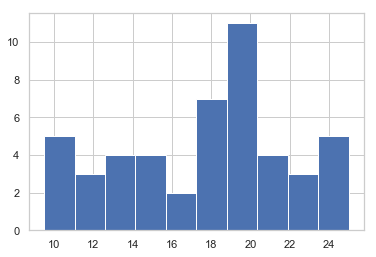

In [71]:
_ = data['sodium'].hist()

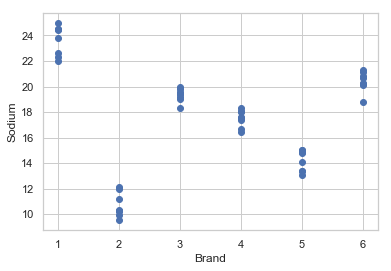

In [73]:
_ = plt.plot(data['brand'], data['sodium'], 'o')
_ = plt.xlabel('Brand')
_ = plt.ylabel('Sodium')

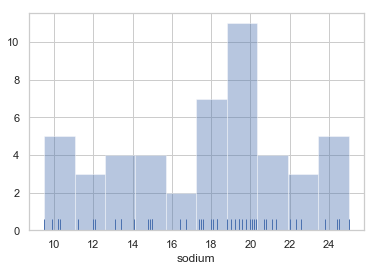

In [84]:
_ = sns.distplot(
    data['sodium'], rug=True, bins=10, kde=False
)

We now visualize the variability across brands

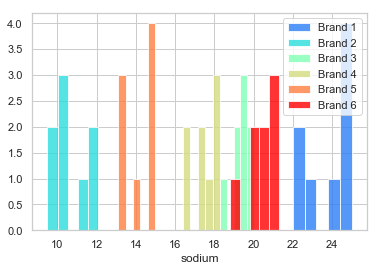

In [121]:
cmap = plt.cm.get_cmap('rainbow')

for b in data['brand'].unique():
    hist_y = data[data['brand'] == b]['sodium']
    _ = sns.distplot(
        hist_y,
        bins=5,
        kde=False,
        label='Brand ' + str(b),
        color=cmap(b / len(data['brand'].unique())),
        hist_kws={'alpha': 0.8},
    )
# end for
_ = plt.legend(loc='best')

### Perform Linear Regression

We start with a simple model in which the sodium in a sample depends only on the brand.  Either by the Linear Regression, or by the subsequent ANOVA, we find we can reject the Null Hypothesis that sodium content is independent of brand

In [106]:
data['brand'] = data['brand'].astype('category')

In [30]:
res3 = ols('sodium ~ brand ', data=data).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sodium   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           1.08e-29
Time:                        21:26:12   Log-Likelihood:                -56.885
No. Observations:                  48   AIC:                             125.8
Df Residuals:                      42   BIC:                             137.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.6375      0.299     79.014      0.000      23.034      24.241
brand[T.2]   -12.9625      0.423    -30.639      0.000     -13.816     -12.109
brand[T.3]    -4.3000      0.423    -10.164      0.000      -5.154      -3.446
brand[T.4]    -6.1375      0.423    -14.507      0.000      -6.991      -5.284
brand[T.5]    -9.4250      0.423    -22.278      0.000     -10.279      -8.571
brand[T.6]    -3.2250      0.423     -7.623      0.000      -4.079      -2.371
==============================================================================
Omnibus:                        2.951   Durbin-Watson:                   2.705
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                1.915
Skew:                          -0.271   Prob(JB):                        0.384
Kurtosis:                       2.185   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
sm.stats.anova_lm(res3)

,df,sum_sq,mean_sq,F,PR(>F)
brand,5.0,854.529167,170.905833,238.711174,1.083746e-29
Residual,42.0,30.070000,0.715952,NaN,NaN


In [32]:
res3.params

Intercept     23.6375
brand[T.2]   -12.9625
brand[T.3]    -4.3000
brand[T.4]    -6.1375
brand[T.5]    -9.4250
brand[T.6]    -3.2250
dtype: float64

To find the brands with a sodium level significantly different from the global average:

In [37]:
#  create a new column for sodium difference from mean
data['na'] = data['sodium'] - data['sodium'].mean()

res3x = ols('na ~ brand -1', data=data).fit()
res3x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     na   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           1.08e-29
Time:                        21:30:24   Log-Likelihood:                -56.885
No. Observations:                  48   AIC:                             125.8
Df Residuals:                      42   BIC:                             137.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
brand[1]       6.0083      0.299     20.084      0.000       5.405       6.612
brand[2]      -6.9542      0.299    -23.246      0.000      -7.558      -6.350
brand[3]       1.7083      0.299      5.711      0.000       1.105       2.312
brand[4]      -0.1292      0.299     -0.432      0.668      -0.733       0.475
brand[5]      -3.4167      0.299    -11.421      0.000      -4.020      -2.813
brand[6]       2.7833      0.299      9.304      0.000       2.180       3.387
==============================================================================
Omnibus:                        2.951   Durbin-Watson:                   2.705
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                1.915
Skew:                          -0.271   Prob(JB):                        0.384
Kurtosis:                       2.185   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that Brand 4 is close to the global average, the other brands are not.

-----------

We can visualize the spread of values across brands

In [27]:
brand_means = [
    res3.predict({'brand': b})[0]
    for b in data['brand'].unique()
]
brand_means

[23.63750000000002,
 10.675000000000011,
 19.33750000000001,
 17.50000000000001,
 14.212500000000013,
 20.41250000000001]

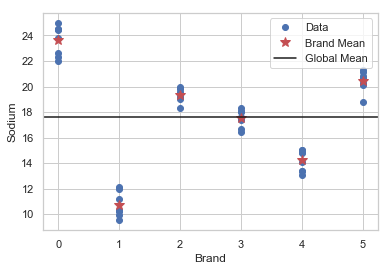

In [142]:
_ = plt.plot(
    data['brand'], data['sodium'], 'o', label='Data'
)
_ = plt.plot(
    data['brand'].unique(),
    brand_means,
    'r*',
    label='Brand Mean',
    markersize=10,
    alpha=1,
)
_ = plt.xlabel('Brand')
_ = plt.ylabel('Sodium')

_ = plt.axhline(
    data['sodium'].mean(), color='k', label='Global Mean'
)
_ = plt.legend(loc='best')

-----
### 'Mixed Effects'

"Mixed Effects" describe situations where we have repeated measurements on the item under consideration (e.g. repeated sampling of different bottles with each brand).  We have different model fitting function calls for this situation.

We now move to a more detailed model

```Na(b,s) ~ Na.global + Na.brand_offset(b) + error(b,s)```

where b runs over all brands, s runs over all samples within a brand. The model is one having a global sodium mean, with a different offset for each brand.  For each sample within a brand, there a measurement error.  We assume that the measurement error is Normally distributed, with a common varience across all brands and samples: i.e. ```error(b,s)``` is ```N(0, sigma)```

In this model, observations are __not__ independent from every other observation.

-----
#### Perform Maximum Likelihood Estimation

Under the Null Hypothesis, all brands are alike, so the ```Na.brand_offset(b)``` values above (in our model) are zero.  We fit a model for this  (i.e. sodium content is a constant, independent of brand)

In [47]:
data = pd.read_fwf('../data/sodium.txt')
data['brand'] = data['brand'].astype('category')
res4 = mixedlm(
    'sodium ~ 1', groups=data['brand'], data=data
).fit()
res4.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: sodium  
No. Observations: 48      Method:             REML    
No. Groups:       6       Scale:              0.7160  
Min. group size:  8       Likelihood:         -74.4615
Max. group size:  8       Converged:          Yes     
Mean group size:  8.0                                 
------------------------------------------------------
             Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    17.629    1.887 9.344 0.000 13.931 21.327
Group Var    21.267   16.880                          
======================================================

"""

We can reject the Null Hypothesis.  We can the 5% confidence limits on sodium content in this model, using the standard error of the intercept from the covariance matrix, as below

In [171]:
int_std_err = np.sqrt(res4.cov_params().iloc[0, 0])

conf_int = (
    mu - int_std_err * stats.t.ppf(0.975, 42),
    mu,
    mu + int_std_err * stats.t.ppf(0.975, 42),
)
conf_int

(13.821797611112494, 17.629166666666663, 21.43653572222083)

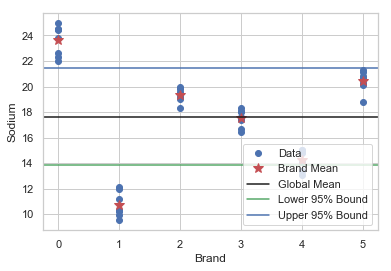

In [169]:
_ = plt.plot(
    data['brand'], data['sodium'], 'o', label='Data'
)
_ = plt.plot(
    data['brand'].unique(),
    brand_means,
    'r*',
    label='Brand Mean',
    markersize=10,
    alpha=1,
)
_ = plt.xlabel('Brand')
_ = plt.ylabel('Sodium')

_ = plt.axhline(
    data['sodium'].mean(), color='k', label='Global Mean'
)
_ = plt.axhline(
    conf_int[0], color='g', label='Lower 95% Bound'
)
_ = plt.axhline(
    conf_int[2], color='b', label='Upper 95% Bound'
)

_ = plt.legend(loc='lower right')

We see that the first two brands may well be outliers

-----
## Environment


In [159]:
%watermark -h -iv
%watermark

numpy       1.15.4
pandas      1.0.0
statsmodels 0.9.0
scipy       1.1.0
matplotlib  3.0.2
seaborn     0.9.0
host name: DESKTOP-SODFUN6
2020-03-29T14:58:55+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
